In [1]:
# Uncomment and run these commands in the notebook to install dependencies

# !pip install pandas matplotlib seaborn nltk scikit-learn wordcloud


In [2]:
# General-purpose imports
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK imports
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Word cloud
from wordcloud import WordCloud

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Uncomment and run these lines if you encounter an error with NLTK resources in cell [4]

#import nltk
# nltk.download('stopwords')  # For stop words
# nltk.download('wordnet')    # For lemmatization
# nltk.download('punkt')      # For tokenization


In [3]:
# Load the dataset
df = pd.read_csv("text.csv")

# Check for missing values
print(df.isnull().sum())

# Drop the 'Unnamed: 0' column
df = df.drop(columns=["Unnamed: 0"])

# Verify changes
print(df.head())



Unnamed: 0    0
text          0
label         0
dtype: int64
                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


In [4]:
# Define features (text) and labels
X = df['text']
y = df['label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)


In [5]:
# Data Preprocessing & Cleaning

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) 

    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)  

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()  #

    # Remove numeric values
    text = re.sub(r'\d+', '', text)  # Remove numbers

    # Lowercasing
    text = text.lower()  

    # Tokenize the text
    words = word_tokenize(text) 

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words] 

    # Remove non-alphanumeric characters 
    words = [word for word in words if word.isalnum()]  

    # Rejoin tokens into a single string
    return ' '.join(words)

# Apply preprocessing to train and test data
X_train_cleaned = X_train.apply(preprocess_text)
X_test_cleaned = X_test.apply(preprocess_text)


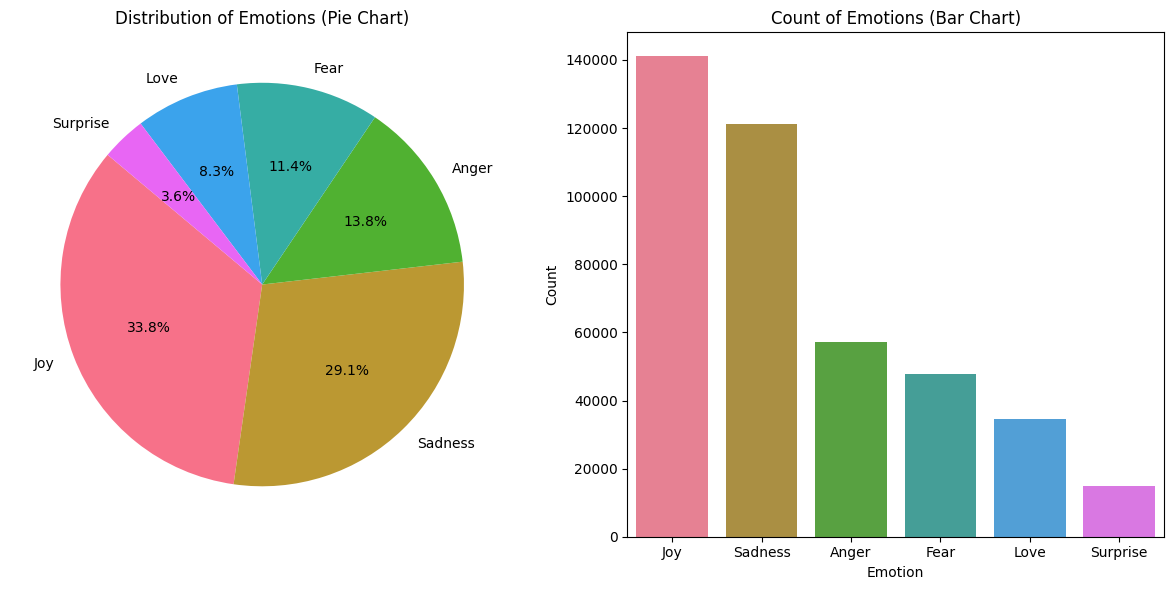

In [6]:
# PIE AND BAR CHART

# Map numeric labels to emotion names
emotion_map = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
df['emotion'] = df['label'].map(emotion_map)

# Count the occurrences of each emotion
count = df['emotion'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Define a color palette
palette = sns.color_palette("husl")
sns.set_palette(palette)

# Plot pie chart on the first subplot
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140, colors=palette)
axs[0].set_title('Distribution of Emotions (Pie Chart)')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], hue=count.index, palette="husl", dodge=False)
axs[1].set_title('Count of Emotions (Bar Chart)')
axs[1].set_xlabel('Emotion')
axs[1].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


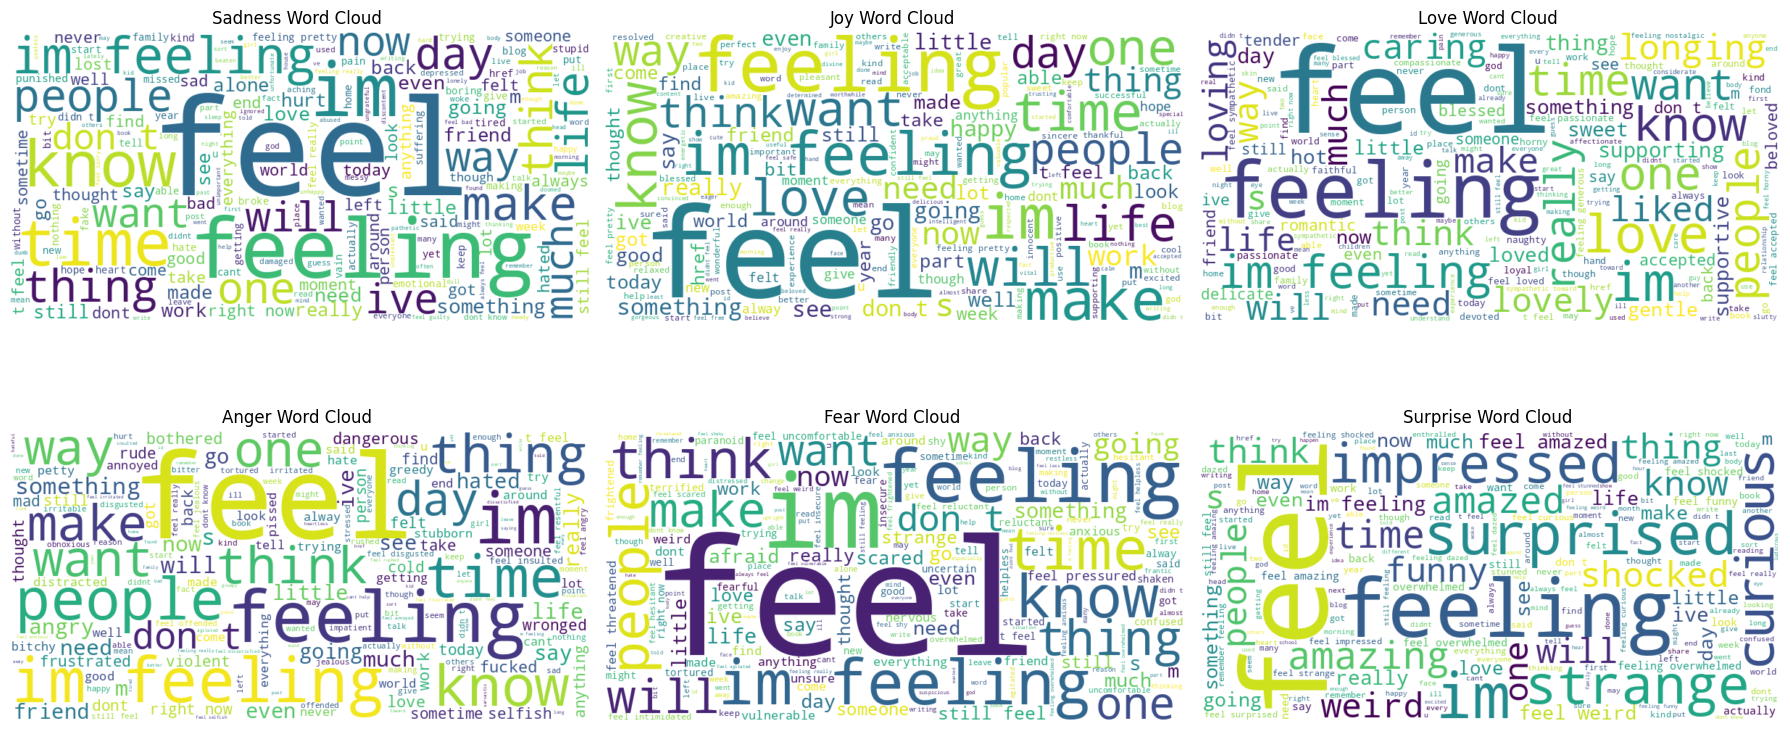

In [7]:
# BAG OF WORDS

# Filter and combine text for each emotion
emotions = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

# Create a dictionary to store combined text for each emotion
combined_text = {emotion: ' '.join(df[df['label'] == label]['text']) for label, emotion in emotions.items()}

# Generate word clouds for each emotion
wordclouds = {emotion: WordCloud(width=800, height=400, background_color='white').generate(text)
              for emotion, text in combined_text.items()}

# Plot the word clouds
plt.figure(figsize=(18, 9))

for i, (emotion, wordcloud) in enumerate(wordclouds.items(), start=1):
    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{emotion} Word Cloud ')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Re-encode the label column back to integers if needed
df['label'] = df['label'].replace({v: k for k, v in emotions.items()})


In [8]:
# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer() 
X_train_tfidf = vectorizer.fit_transform(X_train_cleaned)  # Fit and transform the training data
X_test_tfidf = vectorizer.transform(X_test_cleaned)  # Transform the test data

# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predict on the test data
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 89.42%


--- Classification Report ---
              precision    recall  f1-score   support

     Sadness       0.94      0.94      0.94     12119
         Joy       0.91      0.93      0.92     14107
        Love       0.80      0.75      0.77      3455
       Anger       0.89      0.90      0.89      5732
        Fear       0.84      0.84      0.84      4771
    Surprise       0.74      0.71      0.72      1497

    accuracy                           0.89     41681
   macro avg       0.85      0.84      0.85     41681
weighted avg       0.89      0.89      0.89     41681



<Figure size 1000x700 with 0 Axes>

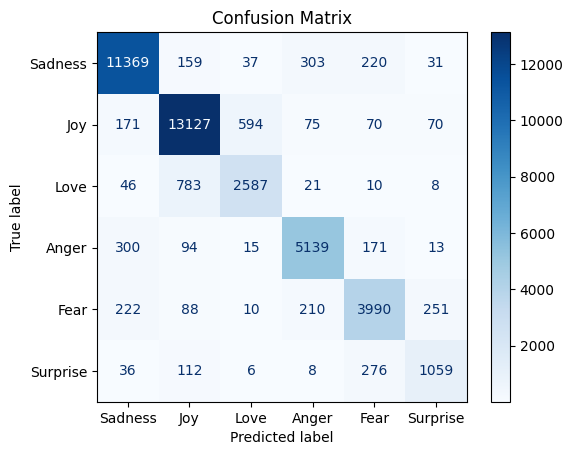

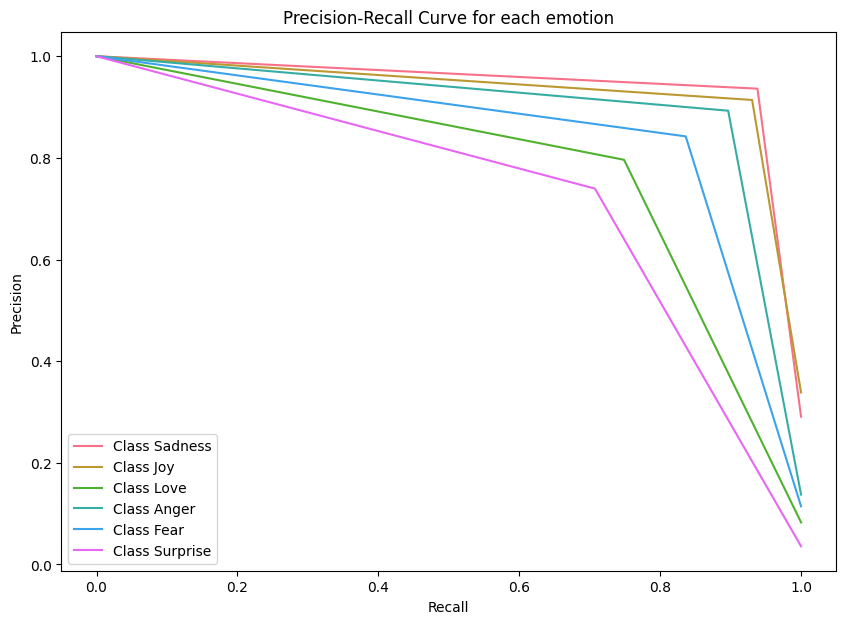

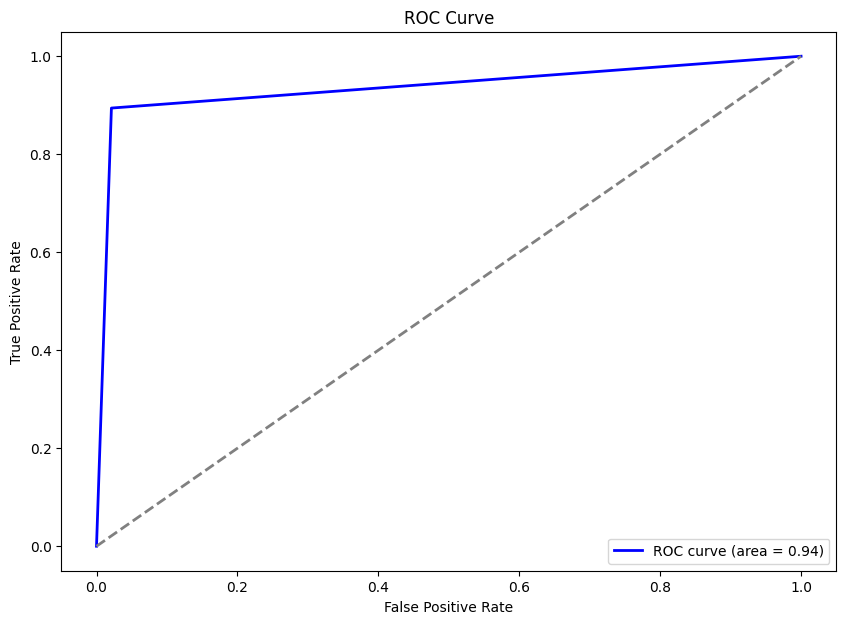

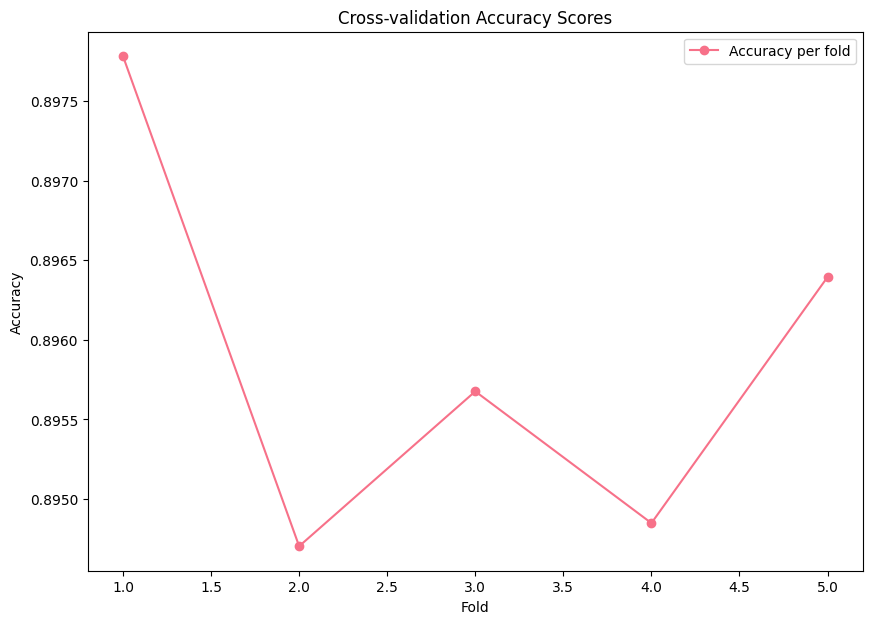

Mean Accuracy (cross-validation): 89.59%
Standard Deviation of Accuracy (cross-validation): 0.11%


In [9]:
# 1. Classification Report (Precision, Recall, F1-score)
target_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']

print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=target_names))

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions.values())

plt.figure(figsize=(10, 7))
cm_display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# 3. Precision-Recall Curve 
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5])

plt.figure(figsize=(10, 7))
for i in range(6):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, label=f'Class {emotions[i]}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each emotion')
plt.legend()
plt.show()

# 4. ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 5. Visualize the Accuracy over multiple folds with Cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, vectorizer.transform(X_train_cleaned), y_train, cv=5, scoring='accuracy')

plt.figure(figsize=(10, 7))
plt.plot(range(1, 6), cv_scores, marker='o', label='Accuracy per fold')
plt.title('Cross-validation Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 6. Summary of Model Performance
print(f"Mean Accuracy (cross-validation): {cv_scores.mean() * 100:.2f}%")
print(f"Standard Deviation of Accuracy (cross-validation): {cv_scores.std() * 100:.2f}%")


In [10]:
# Comparing Other Models Accuracy

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

models = {
    "Linear SVC": LinearSVC(),
    "Naive Bayes": MultinomialNB()
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    score = model.score(X_test_tfidf, y_test)
    print(f"{name} Accuracy: {score:.2%}")

Linear SVC Accuracy: 88.72%
Naive Bayes Accuracy: 77.65%
